In [1]:
!pip install feature_engine -q

In [2]:
!pip install category_encoders -q

# imports

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from category_encoders.ordinal import OrdinalEncoder
from sklearn import tree
#from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import (
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score, 
    confusion_matrix, 
    classification_report
)
import joblib

In [4]:
# to display all the columns of the dataframe in the notebook
pd.pandas.set_option('display.max_columns', None)

# read dataframe

In [5]:
path = "../df/train.csv"

df = pd.read_csv(path)
print(df.shape)
df.head(3)

(10000, 16)


,uid,city,description,homeType,latitude,longitude,garageSpaces,hasSpa,yearBuilt,numOfPatioAndPorchFeatures,lotSizeSqFt,avgSchoolRating,MedianStudentsPerTeacher,numOfBathrooms,numOfBedrooms,priceRange
0,1748,austin,MULTIPLE OFFERS submit best & final to Agent b...,Single Family,30.380089,-97.800621,0,False,1988,0,102366.0,7.000000,17,4.0,4,650000+
1,13380,austin,"4644 Hoffman Dr, Austin, TX 78749 is a single ...",Single Family,30.199486,-97.859947,0,False,1997,0,6534.0,6.666667,16,3.0,4,350000-450000
2,4115,austin,"6804 Canal St, Austin, TX 78741 is a single fa...",Single Family,30.227398,-97.696083,0,False,1952,0,5619.0,3.333333,11,1.0,2,0-250000


# Feature selection and engineering

In [6]:
df.dtypes

uid                             int64
city                           object
description                    object
homeType                       object
latitude                      float64
longitude                     float64
garageSpaces                    int64
hasSpa                           bool
yearBuilt                       int64
numOfPatioAndPorchFeatures      int64
lotSizeSqFt                   float64
avgSchoolRating               float64
MedianStudentsPerTeacher        int64
numOfBathrooms                float64
numOfBedrooms                   int64
priceRange                     object
dtype: object

In [7]:
df['description'].unique()

array(['MULTIPLE OFFERS submit best & final to Agent by Mon 21st - 5pm. Appt with Agent.  RARE PANORAMIC VIEW LOT IN JESTER ESTATES SEE FOR MILES!!  Home sits on Cul-de-sac & backs to a Preserve.  Stunning remodeled Kitchen & Bathrooms. Master suite is a private sanctuary with chic master bath, huge bedroom, walk-in closet & private deck.  Jester has a pool, park, tennis courts & feeds into Anderson High.  This home has been well loved & features 3 living areas, an office, & 3 car garage.',
       '4644 Hoffman Dr, Austin, TX 78749 is a single family home that contains 2,059 sq ft and was built in 1997. It contains 4 bedrooms and 3 bathrooms. \r\n \r\n',
       '6804 Canal St, Austin, TX 78741 is a single family home that contains 832 sq ft and was built in 1952. It contains 2 bedrooms and 1 bathroom. \r\n \r\n',
       ...,
       '7322 Gaines Mill Ln, Austin, TX 78745 is a single family home that contains 1,779 sq ft and was built in 1981. It contains 3 bedrooms and 2 bathrooms. \r\n

In [8]:
df['city'].unique()

array(['austin', 'pflugerville', 'del valle', 'manchaca',
       'dripping springs', 'west lake hills', 'driftwood'], dtype=object)

In [9]:
df['homeType'].unique()

array(['Single Family', 'Multiple Occupancy', 'Condo', 'Apartment',
       'MultiFamily', 'Townhouse', 'Other', 'Residential',
       'Mobile / Manufactured', 'Vacant Land'], dtype=object)

In [10]:
df['priceRange'].unique()

array(['650000+', '350000-450000', '0-250000', '450000-650000',
       '250000-350000'], dtype=object)

In [11]:
df.drop(columns=["uid", "description"], axis=1, inplace=True)
df.head(1)

,city,homeType,latitude,longitude,garageSpaces,hasSpa,yearBuilt,numOfPatioAndPorchFeatures,lotSizeSqFt,avgSchoolRating,MedianStudentsPerTeacher,numOfBathrooms,numOfBedrooms,priceRange
0,austin,Single Family,30.380089,-97.800621,0,False,1988,0,102366.0,7.0,17,4.0,4,650000+


In [12]:
df.isnull().any()

city                          False
homeType                      False
latitude                      False
longitude                     False
garageSpaces                  False
hasSpa                        False
yearBuilt                     False
numOfPatioAndPorchFeatures    False
lotSizeSqFt                   False
avgSchoolRating               False
MedianStudentsPerTeacher      False
numOfBathrooms                False
numOfBedrooms                 False
priceRange                    False
dtype: bool

In [13]:
cat_vars = [var for var in df.columns if df[var].dtype == 'O' and var != 'priceRange']
cat_vars

['city', 'homeType']

In [14]:
num_vars = [var for var in df.columns if var not in cat_vars and var != 'priceRange']
num_vars

['latitude',
 'longitude',
 'garageSpaces',
 'hasSpa',
 'yearBuilt',
 'numOfPatioAndPorchFeatures',
 'lotSizeSqFt',
 'avgSchoolRating',
 'MedianStudentsPerTeacher',
 'numOfBathrooms',
 'numOfBedrooms']

In [15]:
df['hasSpa'] = df['hasSpa'].replace({True: 1, False: 0})

In [16]:
mapping = {'0-250000': 0, '250000-350000': 1, '350000-450000': 2, '450000-650000': 3, '250000-350000': 4, '650000+': 5}

df['priceRange'] = df['priceRange'].map(mapping)

In [17]:
# Let's separate into train and test set
# Remember to set the seed (random_state for this sklearn function)
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['priceRange'], axis=1), # predictive variables
    df['priceRange'], # target
    test_size=0.3, # portion of dataset to allocate to test set
    random_state=0, # we are setting the seed here
)

X_train.shape, X_test.shape

((7000, 13), (3000, 13))

In [18]:
ordinal_enc = OrdinalEncoder(
    cols=cat_vars,
)

ordinal_enc.fit(X_train)

OrdinalEncoder(cols=['city', 'homeType'],
               mapping=[{'col': 'city', 'data_type': dtype('O'),
                         'mapping': austin              1
driftwood           2
del valle           3
pflugerville        4
dripping springs    5
west lake hills     6
manchaca            7
NaN                -2
dtype: int64},
                        {'col': 'homeType', 'data_type': dtype('O'),
                         'mapping': Single Family            1
Condo                    2
Townhouse                3
Multiple Occupancy       4
Residential              5
MultiFamily              6
Apartment                7
Mobile / Manufactured    8
Vacant Land              9
NaN                     -2
dtype: int64}])

In [19]:
# in the mapping we can observe the numbers
# assigned to each category for all the indicated variables
ordinal_enc.mapping

[{'col': 'city',
  'mapping': austin              1
  driftwood           2
  del valle           3
  pflugerville        4
  dripping springs    5
  west lake hills     6
  manchaca            7
  NaN                -2
  dtype: int64,
  'data_type': dtype('O')},
 {'col': 'homeType',
  'mapping': Single Family            1
  Condo                    2
  Townhouse                3
  Multiple Occupancy       4
  Residential              5
  MultiFamily              6
  Apartment                7
  Mobile / Manufactured    8
  Vacant Land              9
  NaN                     -2
  dtype: int64,
  'data_type': dtype('O')}]

In [20]:
# save the model
path_ordinal_encoder_model = '../models/ordinal_encoder_model.joblib'
joblib.dump(ordinal_enc, path_ordinal_encoder_model) 

['../models/ordinal_encoder_model.joblib']

In [21]:
X_train = ordinal_enc.transform(X_train)
X_test = ordinal_enc.transform(X_test)

In [22]:
# Specify the columns you want to scale
#columns_to_scale = ['latitude', 'longitude',
#       'garageSpaces', 'yearBuilt', 'numOfPatioAndPorchFeatures',
#       'lotSizeSqFt', 'avgSchoolRating', 'MedianStudentsPerTeacher',
#       'numOfBathrooms', 'numOfBedrooms']

# Initialize the MinMaxScaler
#scaler = MinMaxScaler()

# Fit the scaler to the selected columns
#scaler.fit(X_train[num_vars])



In [23]:
# Transform the selected columns
#X_train[num_vars] = scaler.transform(X_train[num_vars])
#X_test[num_vars] = scaler.transform(X_test[num_vars])

In [24]:
clf = tree.DecisionTreeClassifier(random_state=0)
clf = clf.fit(X_train, y_train)

In [25]:
path_clf_model = '../models/clf_model.joblib'
joblib.dump(clf, path_clf_model) 

['../models/clf_model.joblib']

# Metrics

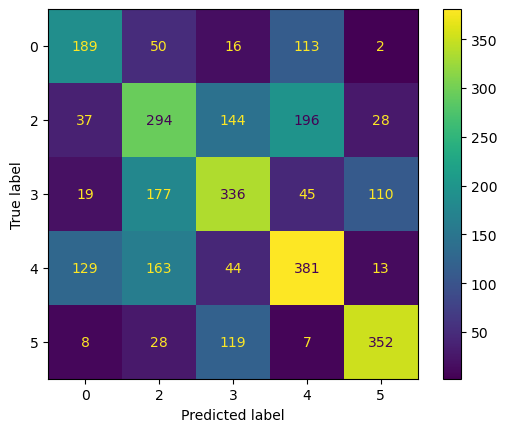

In [26]:
y_pred = clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=clf.classes_)
disp.plot()

In [27]:
# Calculate classification metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

# Print the metrics
print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')
print('\nConfusion Matrix:\n', conf_matrix)
print('\nClassification Report:\n', classification_rep)


Accuracy: 0.52
Precision: 0.52
Recall: 0.52
F1 Score: 0.52

Confusion Matrix:
 [[189  50  16 113   2]
 [ 37 294 144 196  28]
 [ 19 177 336  45 110]
 [129 163  44 381  13]
 [  8  28 119   7 352]]

Classification Report:
               precision    recall  f1-score   support

           0       0.49      0.51      0.50       370
           2       0.41      0.42      0.42       699
           3       0.51      0.49      0.50       687
           4       0.51      0.52      0.52       730
           5       0.70      0.68      0.69       514

    accuracy                           0.52      3000
   macro avg       0.53      0.53      0.53      3000
weighted avg       0.52      0.52      0.52      3000



In [28]:
# Feature importance
feature_importance = clf.feature_importances_

feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importance})

print(feature_importance_df)


                       Feature  Importance
0                         city    0.000702
1                     homeType    0.009035
2                     latitude    0.219034
3                    longitude    0.173228
4                 garageSpaces    0.039104
5                       hasSpa    0.010331
6                    yearBuilt    0.111732
7   numOfPatioAndPorchFeatures    0.040085
8                  lotSizeSqFt    0.154764
9              avgSchoolRating    0.099574
10    MedianStudentsPerTeacher    0.022435
11              numOfBathrooms    0.083605
12               numOfBedrooms    0.036372


# Score New Data

In [29]:
from pipeline import pipeline

In [30]:
path = "../df/train.csv"
df = pd.read_csv(path)

In [31]:
df.columns

Index(['uid', 'city', 'description', 'homeType', 'latitude', 'longitude',
       'garageSpaces', 'hasSpa', 'yearBuilt', 'numOfPatioAndPorchFeatures',
       'lotSizeSqFt', 'avgSchoolRating', 'MedianStudentsPerTeacher',
       'numOfBathrooms', 'numOfBedrooms', 'priceRange'],
      dtype='object')

In [32]:
new_input = pd.DataFrame(df.iloc[0]).transpose()
new_input

,uid,city,description,homeType,latitude,longitude,garageSpaces,hasSpa,yearBuilt,numOfPatioAndPorchFeatures,lotSizeSqFt,avgSchoolRating,MedianStudentsPerTeacher,numOfBathrooms,numOfBedrooms,priceRange
0,1748,austin,MULTIPLE OFFERS submit best & final to Agent b...,Single Family,30.380089,-97.800621,0,False,1988,0,102366.0,7.0,17,4.0,4,650000+


In [33]:
new_result = pipeline(new_input)
new_result

5